## Dependencies

In [1]:
from openvaccine_scripts import *
import warnings, json
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


SEED = 0
seed_everything(SEED)
warnings.filterwarnings('ignore')

# Model parameters

In [2]:
config = {
  "BATCH_SIZE": 64,
  "EPOCHS": 120,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "PB_SEQ_LEN": 107,
  "PV_SEQ_LEN": 130,
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BATCH_SIZE': 64,
 'EPOCHS': 120,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'PB_SEQ_LEN': 107,
 'PV_SEQ_LEN': 130}

# Load data

In [3]:
database_base_path = '/kaggle/input/stanford-covid-vaccine/'
train = pd.read_json(database_base_path + 'train.json', lines=True)
test = pd.read_json(database_base_path + 'test.json', lines=True)

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 2400


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


Test samples: 3634


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Auxiliary functions

In [4]:
def get_dataset(x, y=None, labeled=True, shuffled=True, batch_size=32, buffer_size=-1, seed=0):
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'inputs_seq': x[:, 0, :, :], 
                                                       'inputs_struct': x[:, 1, :, :], 
                                                       'inputs_loop': x[:, 2, :, :]}, 
                                                      {'outputs': y}))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(({'inputs_seq': x[:, 0, :, :], 
                                                       'inputs_struct': x[:, 1, :, :], 
                                                       'inputs_loop': x[:, 2, :, :]}))
    
    
    if shuffled:
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size)
    
    return dataset

def get_dataset_sampling(x, y=None, shuffled=True, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'inputs_seq': x[:, 0, :, :], 
                                                   'inputs_struct': x[:, 1, :, :], 
                                                   'inputs_loop': x[:, 2, :, :]}, 
                                                  {'outputs': y}))
    
    
    if shuffled:
        dataset = dataset.shuffle(2048, seed=seed)
    
    return dataset

# Model

In [5]:
def model_fn(hidden_dim=384, dropout=.5, pred_len=68, n_outputs=5):
    inputs_seq  = L.Input(shape=(None, 1), name='inputs_seq')  
    inputs_struct  = L.Input(shape=(None, 1), name='inputs_struct')  
    inputs_loop  = L.Input(shape=(None, 1), name='inputs_loop')

    def _one_hot(x, num_classes):
        return K.squeeze(K.one_hot(K.cast(x, 'uint8'), num_classes=num_classes), axis=2)

    ohe_seq = L.Lambda(_one_hot, arguments={'num_classes': len(token2int_seq)}, input_shape=(None, 1))(inputs_seq)
    ohe_struct = L.Lambda(_one_hot, arguments={'num_classes': len(token2int_struct)}, input_shape=(None, 1))(inputs_struct)
    ohe_loop = L.Lambda(_one_hot, arguments={'num_classes': len(token2int_loop)}, input_shape=(None, 1))(inputs_loop)
    
    x_concat = L.concatenate([ohe_seq, ohe_struct, ohe_loop], axis=-1, name='ohe_concatenate')
    
    # Conv block
    x = L.Conv1D(filters=256, 
                 kernel_size=5, 
                 strides=1, 
                 padding='same')(x_concat)
    
    # Recurrent block
    x = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))(x)
    
    x_rec = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))(x)
    x = L.Add()([x_rec, x])
    
    x_rec = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'))(x)
    x = L.Add()([x_rec, x])
    
    
    # Since we are only making predictions on the first part of each sequence, we have to truncate it
    x_truncated = x[:, :pred_len]
    
    outputs = L.Dense(n_outputs, activation='linear', name='outputs')(x_truncated)

    model = Model(inputs=[inputs_seq, inputs_struct, inputs_loop], outputs=outputs)

    opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    model.compile(optimizer=opt, loss=MCRMSE)

    return model

model = model_fn()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_seq (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_struct (InputLayer)      [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_loop (InputLayer)        [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, 4)      0           inputs_seq[0][0]                 
_______________________________________________________________________________________

# Pre-process

In [6]:
feature_cols = ['sequence', 'structure', 'predicted_loop_type']
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
encoder_list = [token2int_seq, token2int_struct, token2int_loop]

train_features = np.array([preprocess_inputs(train, encoder_list[idx], [col]) for idx, col in enumerate(feature_cols)]).transpose((1, 0, 2, 3))
train_labels = np.array(train[pred_cols].values.tolist()).transpose((0, 2, 1))

public_test = test.query("seq_length == 107").copy()
private_test = test.query("seq_length == 130").copy()

x_test_public = np.array([preprocess_inputs(public_test, encoder_list[idx], [col]) for idx, col in enumerate(feature_cols)]).transpose((1, 0, 2, 3))
x_test_private = np.array([preprocess_inputs(private_test, encoder_list[idx], [col]) for idx, col in enumerate(feature_cols)]).transpose((1, 0, 2, 3))

# To use as stratified col
train['signal_to_noise_int'] = train['signal_to_noise'].astype(int)

# Training

In [7]:
AUTO = tf.data.experimental.AUTOTUNE
skf = StratifiedKFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
history_list = []

oof = train[['id']].copy()
oof_preds = np.zeros(train_labels.shape)
test_public_preds = np.zeros((x_test_public.shape[0], config['PB_SEQ_LEN'], len(pred_cols)))
test_private_preds = np.zeros((x_test_private.shape[0], config['PV_SEQ_LEN'], len(pred_cols)))

for fold,(train_idx, valid_idx) in enumerate(skf.split(train_labels, train['signal_to_noise_int'])):
    if fold >= config['N_USED_FOLDS']:
        break
    print(f'\nFOLD: {fold+1}')

    ### Create datasets
    x_train = train_features[train_idx]
    y_train = train_labels[train_idx]
    x_valid = train_features[valid_idx]
    y_valid = train_labels[valid_idx]
    
    train_ds = get_dataset(x_train, y_train, labeled=True, shuffled=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    valid_ds = get_dataset(x_valid, y_valid, labeled=True, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    oof_ds = get_dataset(train_features[valid_idx], labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_public_ds = get_dataset(x_test_public, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_private_ds = get_dataset(x_test_private, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)


    ### Model
    K.clear_session()
    model = model_fn()

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], restore_best_weights=True, verbose=1)
    rlrp = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, verbose=1)
    
    ### Train
    history = model.fit(train_ds,
                        validation_data=valid_ds,
                        callbacks=[es, rlrp], 
                        epochs=config['EPOCHS'], 
                        batch_size=config['BATCH_SIZE'],
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    ### Inference
    oof_preds[valid_idx] = model.predict(oof_ds)
    
    # Short sequence (public test)
    model = model_fn(pred_len= config['PB_SEQ_LEN'])
    model.load_weights(model_path)
    test_public_preds += model.predict(test_public_ds) * (1 / config['N_USED_FOLDS'])
    
    # Long sequence (private test)
    model = model_fn(pred_len= config['PV_SEQ_LEN'])
    model.load_weights(model_path)
    test_private_preds += model.predict(test_private_ds) * (1 / config['N_USED_FOLDS'])


FOLD: 1
Epoch 1/120
30/30 - 5s - loss: 0.6244 - val_loss: 0.6040
Epoch 2/120
30/30 - 3s - loss: 0.5083 - val_loss: 0.5843
Epoch 3/120
30/30 - 3s - loss: 0.4910 - val_loss: 0.5719
Epoch 4/120
30/30 - 3s - loss: 0.4813 - val_loss: 0.5641
Epoch 5/120
30/30 - 3s - loss: 0.4732 - val_loss: 0.5572
Epoch 6/120
30/30 - 3s - loss: 0.4678 - val_loss: 0.5500
Epoch 7/120
30/30 - 3s - loss: 0.4604 - val_loss: 0.5448
Epoch 8/120
30/30 - 3s - loss: 0.4543 - val_loss: 0.5387
Epoch 9/120
30/30 - 3s - loss: 0.4472 - val_loss: 0.5318
Epoch 10/120
30/30 - 3s - loss: 0.4426 - val_loss: 0.5298
Epoch 11/120
30/30 - 3s - loss: 0.4376 - val_loss: 0.5185
Epoch 12/120
30/30 - 3s - loss: 0.4316 - val_loss: 0.5170
Epoch 13/120
30/30 - 3s - loss: 0.4259 - val_loss: 0.5104
Epoch 14/120
30/30 - 3s - loss: 0.4213 - val_loss: 0.5051
Epoch 15/120
30/30 - 3s - loss: 0.4176 - val_loss: 0.4999
Epoch 16/120
30/30 - 3s - loss: 0.4127 - val_loss: 0.4955
Epoch 17/120
30/30 - 3s - loss: 0.4079 - val_loss: 0.4932
Epoch 18/120
3

## Model loss graph


FOLD: 1
Train 0.31801 Validation 0.45279

FOLD: 2
Train 0.33280 Validation 0.34953

FOLD: 3
Train 0.33637 Validation 0.36604

FOLD: 4
Train 0.33963 Validation 0.37872

FOLD: 5
Train 0.33912 Validation 0.37509


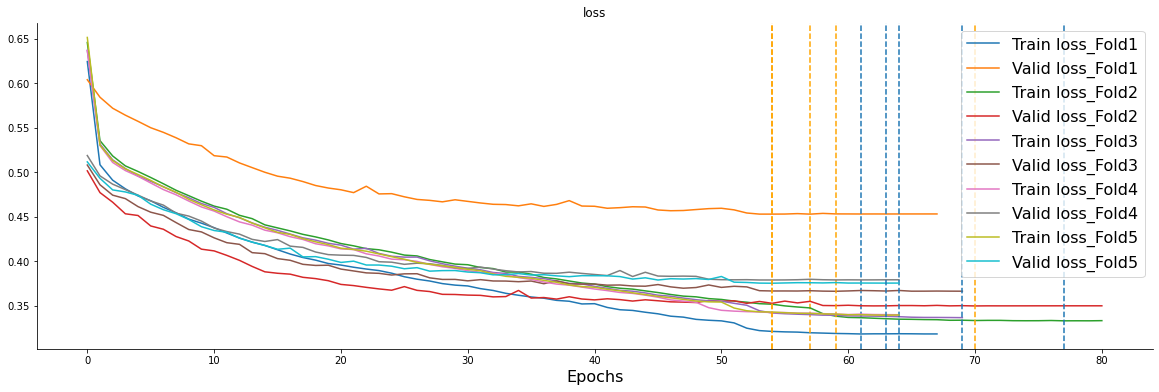

In [8]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    print(f"Train {np.array(history['loss']).min():.5f} Validation {np.array(history['val_loss']).min():.5f}")

plot_metrics_agg(history_list)

# Post-processing

In [9]:
# Assign values to OOF set
# Assign labels
for idx, col in enumerate(pred_cols):
    val = train_labels[:, :, idx]
    oof = oof.assign(**{col: list(val)})

# Assign preds
for idx, col in enumerate(pred_cols):
    val = oof_preds[:, :, idx]
    oof = oof.assign(**{f'{col}_pred': list(val)})
    

# Assign values to test set
preds_ls = []

for df, preds in [(public_test, test_public_preds), (private_test, test_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

# Model evaluation

In [10]:
display(evaluate_model(train, train_labels, oof_preds, pred_cols))

,Metric/MCRMSE,Complete,Clean (SN),Noisy (SN),Clean (signal),Noisy (signal)
0,Overall,0.820088,0.226909,1.369857,0.240747,2.206977
1,reactivity,0.606284,0.211605,1.000026,0.215547,1.606740
2,deg_Mg_pH10,0.544351,0.258816,0.863511,0.259368,1.369500
3,deg_pH10,1.170441,0.240016,1.985241,0.263377,3.215117
4,deg_Mg_50C,0.735662,0.216297,1.228784,0.229835,1.976971
5,deg_50C,1.043703,0.207813,1.771725,0.235606,2.866555


# Visualize test predictions

In [11]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission = submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])

# Test set predictions

In [12]:
display(submission.head(10))
display(submission.describe())

submission.to_csv('submission.csv', index=False)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.695862,0.615149,1.860933,0.569052,0.800880
1,id_00073f8be_1,2.106207,3.098843,3.917808,3.148310,2.775574
2,id_00073f8be_2,1.472300,0.598769,0.534606,0.706704,0.661277
3,id_00073f8be_3,1.289053,1.172398,1.122713,1.672447,1.798862
4,id_00073f8be_4,0.834259,0.565930,0.490181,0.832642,0.891550
5,id_00073f8be_5,0.674558,0.611763,0.612707,0.701916,0.729878
6,id_00073f8be_6,0.462544,0.855174,0.974902,0.891100,0.954597
7,id_00073f8be_7,0.488795,0.784158,1.035546,0.917472,1.252443
8,id_00073f8be_8,0.170679,0.511009,0.523719,0.643192,0.550955
9,id_00073f8be_9,0.168404,0.323294,0.349864,0.416461,0.501479


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
count,457953.000000,457953.000000,457953.000000,457953.000000,457953.000000
mean,0.310299,0.400372,0.387871,0.335741,0.355997
std,0.359451,0.398548,0.431769,0.383244,0.338259
min,-0.319883,-1.051375,-2.545696,-2.066346,-2.032737
25%,0.074162,0.172099,0.146335,0.103348,0.119087
50%,0.182179,0.295119,0.287463,0.241741,0.291338
75%,0.426640,0.481910,0.482760,0.453908,0.524912
max,4.512557,5.499033,6.122743,4.513575,3.647247
